# K-fold

In [1]:
import pandas as pd
wine = pd.read_csv('../data/wine.csv')

data = wine[['alcohol','sugar','pH']].to_numpy()
target = wine['class'].to_numpy()

from sklearn.model_selection import train_test_split
sub_input, test_input, sub_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)
train_input, val_input, train_target, val_target = train_test_split(
    sub_input, sub_target, test_size=0.25, random_state=42)
# 20% of dataset -> test_input
# 80% of dataset -> sub_input
#                -> 25% of sub_input -> val_input (== 20% of dataset)
#                -> 75% of sub_input -> train_input (==60% of dataset)
# train_input:val_input:test_input = 6:2:2
print(f'shape of sub_input: {sub_input.shape}', f'shape of val_input: {val_input.shape}', f'shape of test_input: {test_input.shape}')

shape of sub_input: (5197, 3) shape of val_input: (1300, 3) shape of test_input: (1300, 3)


In [2]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_input, train_target)
print(f'train score: {dt.score(train_input, train_target)}')
print(f'validation score: {dt.score(val_input, val_target)}')
print(f'test score: {dt.score(test_input, test_target)}')

train score: 0.9969207082371054
validation score: 0.86
test score: 0.8423076923076923


In [10]:
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target, cv=5)
print(scores)

import numpy as np
print(f'Mean test score: {np.mean(scores["test_score"])}')

{'fit_time': array([0.00999379, 0.01300263, 0.010993  , 0.01899385, 0.01699162]), 'score_time': array([0.00199842, 0.00298905, 0.00199962, 0.00199008, 0.00099826]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}
Mean test score: 0.855300214703487


In [11]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold()) # StratifiedKFold is default option of cv
print(f'Mean test score: {np.mean(scores["test_score"])}')

Mean test score: 0.855300214703487


In [13]:
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))
print(f'Mean test score: {np.mean(scores["test_score"])}')

Mean test score: 0.8574181117533719


# Grid Search

In [17]:
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)
dt = gs.best_estimator_
print(f'train score: {dt.score(train_input, train_target)}')

train score: 0.9615162593804117


In [20]:
print(gs.best_params_)
cv_results = gs.cv_results_["mean_test_score"]
print(f'cv results: {cv_results}')
best_index = np.argmax(cv_results)
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}
cv results: [0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]
{'min_impurity_decrease': 0.0001}


## More complex parameters

In [21]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)}

In [22]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [25]:
print(gs.best_params_)
print(f'Best test cv score: {np.max(gs.cv_results_["mean_test_score"])}')

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}
Best test cv score: 0.8683865773302731


# Random search

In [26]:
from scipy.stats import uniform, randint
rgen = randint(0, 10) # rgen can generate random int value between 0 through 10
rgen.rvs(10) # sample ten values

array([8, 7, 9, 1, 8, 0, 4, 3, 6, 5], dtype=int64)

In [27]:
np.unique(rgen.rvs(1000), return_counts=True) # sapmle 1000 values

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([111,  85,  95, 121, 100, 108,  91,  94,  95, 100], dtype=int64))

In [28]:
ugen = uniform(0, 1) # ugen can generate real numbers between 0 and 1
ugen.rvs(10)

array([0.08204363, 0.98059428, 0.38605794, 0.16219918, 0.652747  ,
       0.16734458, 0.01501681, 0.53163857, 0.34046187, 0.12949375])

In [30]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25)}

In [35]:
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=10000, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=10000, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E487C72140>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E4873E32E0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E487C72DA0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E487C72C50>},
                   random_state=42)

In [36]:
print(gs.best_params_)
print(f'Best test cv score: {np.max(gs.cv_results_["mean_test_score"])}')

{'max_depth': 21, 'min_impurity_decrease': 0.00042479287078831576, 'min_samples_leaf': 4, 'min_samples_split': 14}
Best test cv score: 0.8705028873917229


In [37]:
dt = gs.best_estimator_
print(f'Test score: {dt.score(test_input, test_target)}')

Test score: 0.8607692307692307


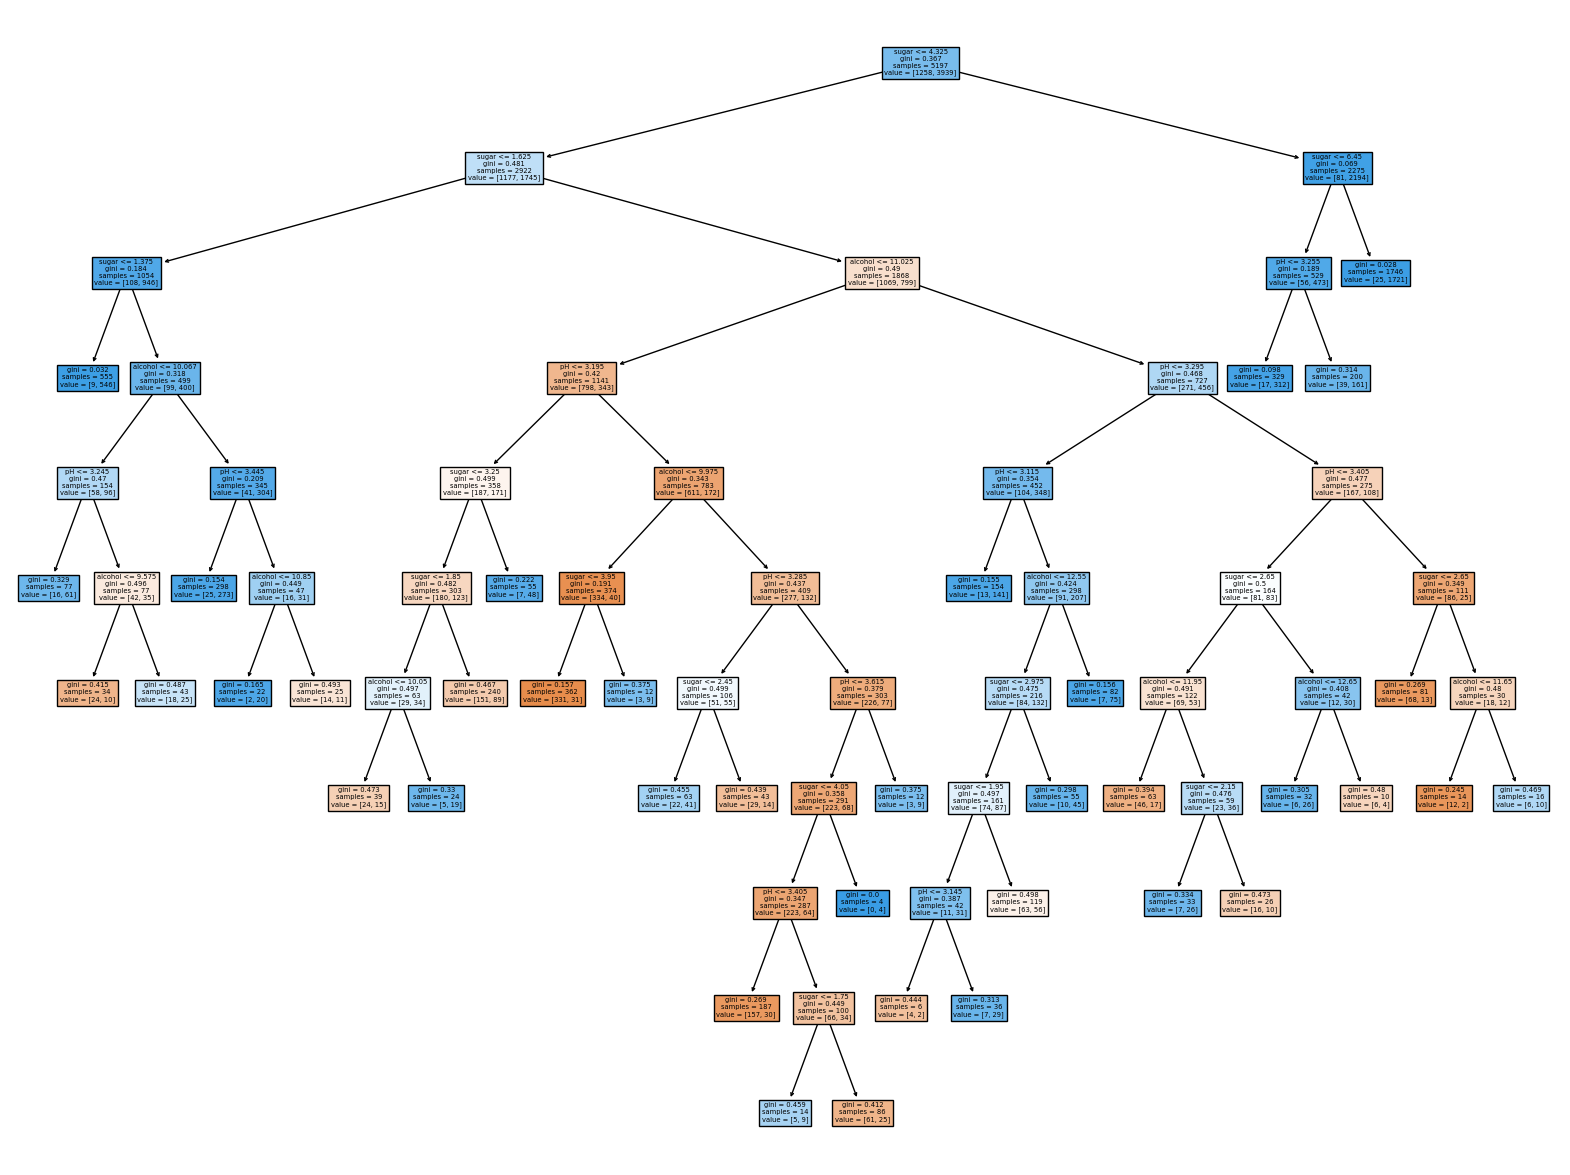

In [40]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()